# Initialization

Automatically search for an NVIDIA GPU and use it. If not, then use CPU

In [1]:
import torch


# Find and use the appropriate GPU/CPU
if torch.cuda.is_available():
    device = torch.device('cuda')
    print('Using GPU')
else:
    device = 'cpu'
    print('Using CPU')

Using GPU


Load all of our preprocessed data from the caches that we generated with the `../preprocessing/sdt/gasdb/create_sdt.py` and `../preprocessing/split_data_gasdb.ipynb` files.

In [2]:
import pickle


# Label to use for this model in the plots
model_name = 'CGCNN ensemble'

# Load the data split from our Jupyter notebook cache
with open('../preprocessing/sdt/gasdb/feature_dimensions.pkl', 'rb') as file_handle:
    orig_atom_fea_len, nbr_fea_len = pickle.load(file_handle)

with open('../preprocessing/splits_gasdb.pkl', 'rb') as file_handle:
    splits = pickle.load(file_handle)

docs_train, docs_val = splits['docs_train'], splits['docs_val']
sdts_train, sdts_val = splits['sdts_train'], splits['sdts_val']
targets_train, targets_val = splits['targets_train'], splits['targets_val']

# Define all the adsorbates
adsorbates = list({doc['adsorbate'] for doc in docs_val})
adsorbates.sort()

# Train

In [ ]:
import numpy as np
from sklearn.model_selection import KFold
from torch.optim import Adam
import skorch.callbacks.base
from skorch.callbacks import Checkpoint  # needs skorch >= 0.4
from skorch.callbacks.lr_scheduler import LRScheduler
from skorch import NeuralNetRegressor
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./histories/%i_valid_best_params.pt' % k)

nets = []
# Fold the CV data
k_folder = KFold(n_splits=5)
for k, (indices_train, _) in enumerate(k_folder.split(sdts_train)):
    stds_train_ = [sdts_train[index] for index in indices_train]
    targets_train_ = np.array([targets_train[index] for index in indices_train])

    # Define various callbacks and checkpointers for this network
    LR_schedule = LRScheduler('MultiStepLR', milestones=[75], gamma=0.1)
    cp = Checkpoint(monitor='valid_loss_best', fn_prefix='./histories/%i_valid_best_' % k)
    load_best_valid_loss = train_end_load_best_valid_loss()

    # Train this fold's network
    net = NeuralNetRegressor(
        CrystalGraphConvNet,
        module__orig_atom_fea_len=orig_atom_fea_len,
        module__nbr_fea_len=nbr_fea_len,
        batch_size=214,
        module__classification=False,
        lr=0.0056,
        max_epochs=100,
        module__atom_fea_len=46,
        module__h_fea_len=83,
        module__n_conv=8,
        module__n_h=4,
        optimizer=Adam,
        iterator_train__pin_memory=True,
        iterator_train__num_workers=0,
        iterator_train__collate_fn=collate_pool,
        iterator_train__shuffle=True,
        iterator_valid__pin_memory=True,
        iterator_valid__num_workers=0,
        iterator_valid__collate_fn=collate_pool,
        iterator_valid__shuffle=False,
        device=device,
        criterion=torch.nn.L1Loss,
        dataset=MergeDataset,
        callbacks=[cp, load_best_valid_loss, LR_schedule]
    )
    net.initialize()
    net.fit(stds_train_, targets_train_)
    nets.append(net)

# Loading models
It takes a few hours to fit the 5-model ensemble. You can either do it via notebook (above) or via `sbatch submit_ensemble_fitting.sh`. Either way, you load the results here.

In [3]:
import numpy as np
from sklearn.model_selection import KFold
from torch.optim import Adam
import skorch.callbacks.base
from skorch.callbacks import Checkpoint  # needs skorch >= 0.4
from skorch.callbacks.lr_scheduler import LRScheduler
from skorch import NeuralNetRegressor
from cgcnn.model import CrystalGraphConvNet
from cgcnn.data import collate_pool, MergeDataset


class train_end_load_best_valid_loss(skorch.callbacks.base.Callback):
    def on_train_end(self, net, X, y):
        net.load_params('./histories/%i_valid_best_params.pt' % k)

nets = []
# Fold the CV data
k_folder = KFold(n_splits=5)
for k, (indices_train, _) in enumerate(k_folder.split(sdts_train)):
    stds_train_ = [sdts_train[index] for index in indices_train]
    targets_train_ = np.array([targets_train[index] for index in indices_train])

    # Define various callbacks and checkpointers for this network
    LR_schedule = LRScheduler('MultiStepLR', milestones=[75], gamma=0.1)
    cp = Checkpoint(monitor='valid_loss_best', fn_prefix='./histories/%i_valid_best_' % k)
    load_best_valid_loss = train_end_load_best_valid_loss()

    # Train this fold's network
    net = NeuralNetRegressor(
        CrystalGraphConvNet,
        module__orig_atom_fea_len=orig_atom_fea_len,
        module__nbr_fea_len=nbr_fea_len,
        batch_size=214,
        module__classification=False,
        lr=0.0056,
        max_epochs=100,
        module__atom_fea_len=46,
        module__h_fea_len=83,
        module__n_conv=8,
        module__n_h=4,
        optimizer=Adam,
        iterator_train__pin_memory=True,
        iterator_train__num_workers=0,
        iterator_train__collate_fn=collate_pool,
        iterator_train__shuffle=True,
        iterator_valid__pin_memory=True,
        iterator_valid__num_workers=0,
        iterator_valid__collate_fn=collate_pool,
        iterator_valid__shuffle=False,
        device=device,
        criterion=torch.nn.L1Loss,
        dataset=MergeDataset,
        callbacks=[cp, load_best_valid_loss, LR_schedule]
    )
    net.initialize()
    net.load_params(f_history='./histories/%i_valid_best_history.json' % k,
                    f_optimizer='./histories/%i_valid_best_optimizer.pt' % k, 
                    f_params='./histories/%i_valid_best_params.pt' % k)
    nets.append(net)

# Ensembling
Wrap the five networks together

In [4]:
class Ensemble:
    def __init__(self, networks):
        self.networks = networks

    def predict(self, features):
        # Make the prediction for this network
        for net in self.networks:
            prediction = net.predict(features)

            # Concatenate this network's predictions with the previous ones
            try:
                predictions = np.hstack((predictions, prediction))

            # If this is the first network to make predictions,
            # then initialize the `predictions` output
            except NameError:
                predictions = prediction
        return predictions


ensemble = Ensemble(nets)
preds = ensemble.predict(sdts_val)

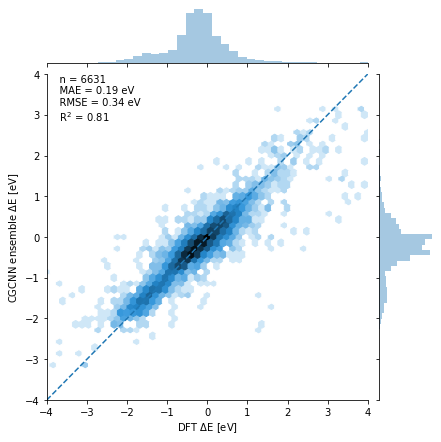

In [5]:
%matplotlib inline
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


# Make the predictions
predictions = ensemble.predict(sdts_val)
targets_pred = predictions.mean(axis=1)
residuals = targets_pred - targets_val.reshape(-1)
stdevs = predictions.std(axis=1)

# Plot
lims = [-4, 4]
grid = sns.jointplot(targets_val.reshape(-1), targets_pred,
                     kind='hex',
                     bins='log',
                     extent=lims+lims)
ax = grid.ax_joint
_ = ax.set_xlim(lims)
_ = ax.set_ylim(lims)
_ = ax.plot(lims, lims, '--')
_ = ax.set_xlabel('DFT $\Delta$E [eV]')
_ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)

# Calculate the error metrics
mae = mean_absolute_error(targets_val, targets_pred)
rmse = np.sqrt(mean_squared_error(targets_val, targets_pred))
r2 = r2_score(targets_val, targets_pred)

# Report
text = ('    n = %i\n'
        '    MAE = %.2f eV\n'
        '    RMSE = %.2f eV\n'
        '    R$^2$ = %.2f'
        % (len(targets_val), mae, rmse, r2))
_ = ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

In [6]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


def calculate_density(percentile):
    num_within_quantile = 0
    for stdev, resid in zip(stdevs, residuals):
        norm = stats.norm(loc=0, scale=stdev)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

predicted_pi = np.linspace(0, 1, 20)
observed_pi = [calculate_density(quantile)
               for quantile in tqdm_notebook(predicted_pi, desc='Calibration')]

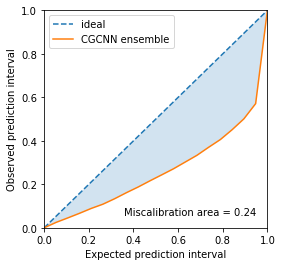

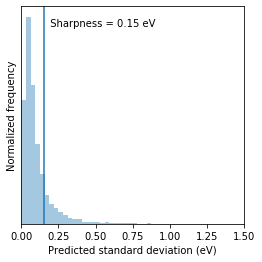

In [7]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon


# Plot settings
figsize = (4, 4)

# Plot the calibration curve
fig_cal = plt.figure(figsize=figsize)
ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal')
_ = ax_ideal.lines[0].set_linestyle('--')
ax_gp = sns.lineplot(predicted_pi, observed_pi, label=model_name)
ax_fill = plt.fill_between(predicted_pi, predicted_pi, observed_pi,
                           alpha=0.2, label='miscalibration area')
_ = ax_ideal.set_xlabel('Expected prediction interval')
_ = ax_ideal.set_ylabel('Observed prediction interval')
_ = ax_ideal.set_xlim([0, 1])
_ = ax_ideal.set_ylim([0, 1])

# Calculate the miscalibration area.
polygon_points = []
for point in zip(predicted_pi, observed_pi):
    polygon_points.append(point)
for point in zip(reversed(predicted_pi), reversed(predicted_pi)):
    polygon_points.append(point)
polygon_points.append((predicted_pi[0], observed_pi[0]))
polygon = Polygon(polygon_points)
miscalibration_area = polygon.area

# Annotate the plot with the miscalibration area
plt.text(x=0.95, y=0.05,
         s='Miscalibration area = %.2f' % miscalibration_area,
         verticalalignment='bottom',
         horizontalalignment='right')


# Plot sharpness curve
xlim = [0, 1.5]
fig_sharp = plt.figure(figsize=figsize)
ax_sharp = sns.distplot(stdevs, kde=False, norm_hist=True)
ax_sharp.set_xlim(xlim)
ax_sharp.set_xlabel('Predicted standard deviation (eV)')
ax_sharp.set_ylabel('Normalized frequency')
ax_sharp.set_yticklabels([])
ax_sharp.set_yticks([])

# Calculate and report sharpness
sharpness = np.sqrt(np.mean(stdevs**2))
_ = ax_sharp.axvline(x=sharpness, label='sharpness')
if sharpness < (xlim[0] + xlim[1]) / 2:
    text = '\n  Sharpness = %.2f eV' % sharpness
    h_align = 'left'
else:
    text = '\nSharpness = %.2f eV  ' % sharpness
    h_align = 'right'
_ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                  s=text,
                  verticalalignment='top',
                  horizontalalignment=h_align)

## Results-by-adsorbate
Let's dig into details and see how our results turned out for each adsorbate. Note that this section shows the results from a single model trained on a pooled dataset. Only the performance metrics are partitioned by adsorbate.

In [8]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import numpy as np


class SeabornFig2Grid():
    '''
    Credit goes to ImportanceOfBeingErnest on StackOverflow
    https://stackoverflow.com/questions/35042255/how-to-plot-multiple-seaborn-jointplot-in-subplot
    '''

    def __init__(self, seaborngrid, fig,  subplot_spec):
        self.fig = fig
        self.sg = seaborngrid
        self.subplot = subplot_spec
        if isinstance(self.sg, sns.axisgrid.FacetGrid) or \
            isinstance(self.sg, sns.axisgrid.PairGrid):
            self._movegrid()
        elif isinstance(self.sg, sns.axisgrid.JointGrid):
            self._movejointgrid()
        self._finalize()

    def _movegrid(self):
        """ Move PairGrid or Facetgrid """
        self._resize()
        n = self.sg.axes.shape[0]
        m = self.sg.axes.shape[1]
        self.subgrid = gridspec.GridSpecFromSubplotSpec(n,m, subplot_spec=self.subplot)
        for i in range(n):
            for j in range(m):
                self._moveaxes(self.sg.axes[i,j], self.subgrid[i,j])

    def _movejointgrid(self):
        """ Move Jointgrid """
        h= self.sg.ax_joint.get_position().height
        h2= self.sg.ax_marg_x.get_position().height
        r = int(np.round(h/h2))
        self._resize()
        self.subgrid = gridspec.GridSpecFromSubplotSpec(r+1,r+1, subplot_spec=self.subplot)

        self._moveaxes(self.sg.ax_joint, self.subgrid[1:, :-1])
        self._moveaxes(self.sg.ax_marg_x, self.subgrid[0, :-1])
        self._moveaxes(self.sg.ax_marg_y, self.subgrid[1:, -1])

    def _moveaxes(self, ax, gs):
        #https://stackoverflow.com/a/46906599/4124317
        ax.remove()
        ax.figure=self.fig
        self.fig.axes.append(ax)
        self.fig.add_axes(ax)
        ax._subplotspec = gs
        ax.set_position(gs.get_position(self.fig))
        ax.set_subplotspec(gs)

    def _finalize(self):
        plt.close(self.sg.fig)
        self.fig.canvas.mpl_connect("resize_event", self._resize)
        self.fig.canvas.draw()

    def _resize(self, evt=None):
        self.sg.fig.set_size_inches(self.fig.get_size_inches())

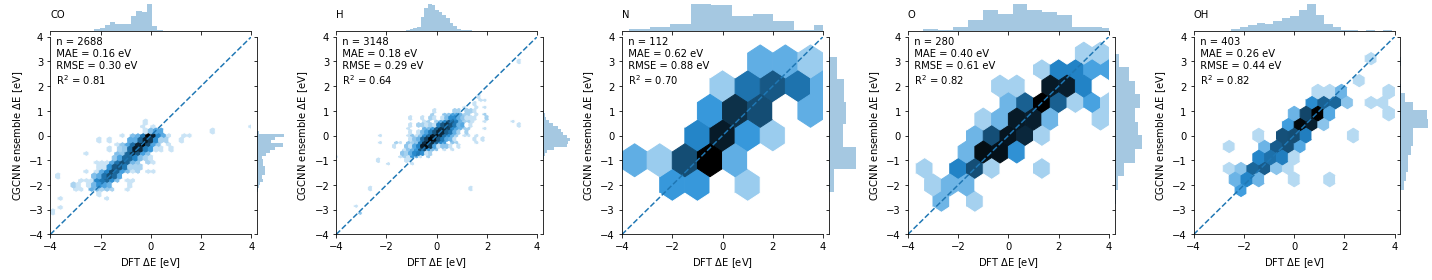

In [9]:
%matplotlib inline
import numpy as np
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns


# Parse the predictions
targets_pred = predictions

# Prepare figure for all adsorbates
fig = plt.figure(figsize=(20, 4))
gs = gridspec.GridSpec(1, len(adsorbates))

# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _targets_val = []
    _targets_pred = []
    for doc, target, pred in zip(docs_val, targets_val, targets_pred):
        if doc['adsorbate'] == ads:
            _targets_val.append(target)
            _targets_pred.append(pred)
    _targets_val = np.array(_targets_val).reshape(-1)
    _targets_pred = np.array(_targets_pred).mean(axis=1).reshape(-1)

    # Plot accuracy
    lims = [-4, 4]
    grid = sns.jointplot(_targets_val, _targets_pred,
                         kind='hex',
                         bins='log',
                         extent=lims*2)
    ax = grid.ax_joint
    _ = ax.set_xlim(lims)
    _ = ax.set_ylim(lims)
    _ = ax.plot(lims, lims, '--')
    _ = ax.set_xlabel('DFT $\Delta$E [eV]')
    _ = ax.set_ylabel('%s $\Delta$E [eV]' % model_name)
    _ = ax.set_title(ads)

    # Calculate + report metrics
    mae = mean_absolute_error(_targets_val, _targets_pred)
    rmse = np.sqrt(mean_squared_error(_targets_val, _targets_pred))
    r2 = r2_score(_targets_val, _targets_pred)
    grid.ax_marg_x.text(x=lims[0], y=0,
                        verticalalignment='bottom',
                        s='%s\n' % ads)
    text = ('  n = %i\n'
            '  MAE = %.2f eV\n'
            '  RMSE = %.2f eV\n'
            '  R$^2$ = %.2f'
            % (len(_targets_val), mae, rmse, r2))
    ax.text(x=lims[0], y=lims[1], s=text,
            horizontalalignment='left',
            verticalalignment='top')

    # Put the figure into the subplot
    sfg = SeabornFig2Grid(grid, fig, gs[i])
gs.tight_layout(fig)

In [10]:
import numpy as np
from scipy import stats
from tqdm import tqdm_notebook


# Create a function that we'll use to calculate calibration curves
def calculate_density(percentile, residuals, stdevs):
    num_within_quantile = 0
    for stdev, resid in zip(stdevs, residuals):
        norm = stats.norm(loc=0, scale=stdev)
        lower_bound = norm.ppf(0.5-percentile/2)
        upper_bound = norm.ppf(0.5+percentile/2)
        if lower_bound <= resid <= upper_bound:
            num_within_quantile += 1
    density = num_within_quantile / len(residuals)
    return density

# Initialize the information we need to make calibration plots
predicted_pi = {}
observed_pi = {}

# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _residuals = []
    _stdevs = []
    for doc, resid, se in zip(docs_val, residuals, stdevs):
        if doc['adsorbate'] == ads:
            _residuals.append(resid)
            _stdevs.append(se)
    _residuals = np.array(_residuals).reshape(-1)
    _stdevs = np.array(_stdevs).reshape(-1)

    # Calculate the prediction intervals
    _predicted_pi = np.linspace(0, 1, 20)
    _observed_pi = [calculate_density(quantile, _residuals, _stdevs)
                    for quantile in tqdm_notebook(_predicted_pi, desc='Calibration')]

    # Store the information
    predicted_pi[ads] = _predicted_pi
    observed_pi[ads] = _observed_pi

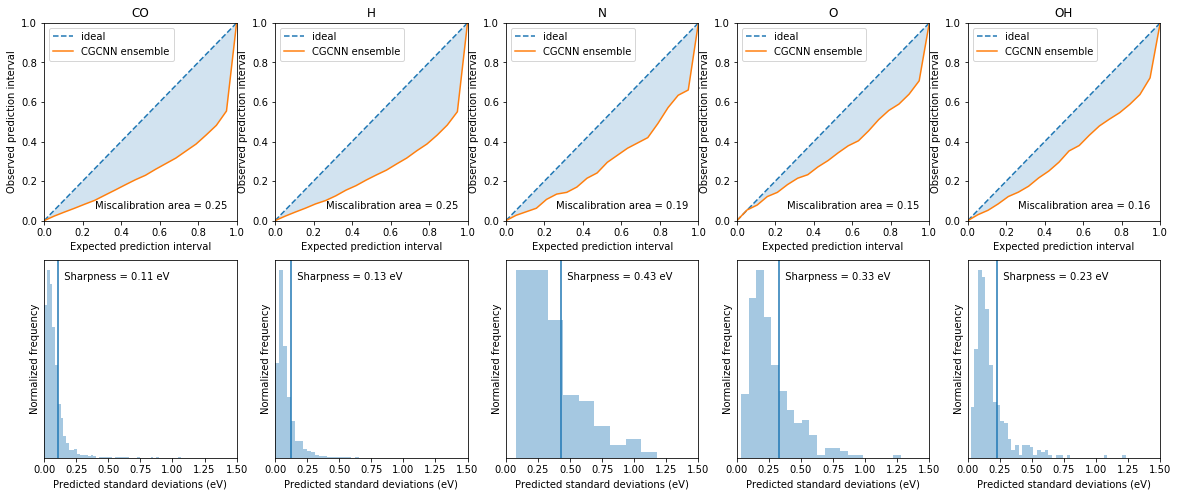

In [11]:
%matplotlib inline
import numpy as np
from scipy import stats
from matplotlib import pyplot as plt
import seaborn as sns
from shapely.geometry import Polygon


# Prepare figure for all adsorbates
figsize = (20, 8)
fig, axes = plt.subplots(2, len(adsorbates), figsize=figsize)
sub_figsize = (figsize[0]/len(adsorbates), figsize[1]/2)


# Parse out the data for each adsorbate
for i, ads in enumerate(adsorbates):
    _stdevs = []
    for doc, stdev in zip(docs_val, stdevs):
        if doc['adsorbate'] == ads:
            _stdevs.append(stdev)
    _stdevs = np.array(_stdevs).reshape(-1)
    _observed_pi = observed_pi[ads]
    _predicted_pi = predicted_pi[ads]

    # Plot the calibration curve
    ax_cal = axes[0][i]
    ax_ideal = sns.lineplot([0, 1], [0, 1], label='ideal', ax=ax_cal)
    _ = ax_ideal.lines[0].set_linestyle('--')
    ax_gp = sns.lineplot(_predicted_pi, _observed_pi, label=model_name, ax=ax_cal)
    ax_fill = ax_cal.fill_between(_predicted_pi, _predicted_pi, _observed_pi,
                                  alpha=0.2)
    _ = ax_ideal.set_xlabel('Expected prediction interval')
    _ = ax_ideal.set_ylabel('Observed prediction interval')
    _ = ax_ideal.set_xlim([0, 1])
    _ = ax_ideal.set_ylim([0, 1])
    _ = ax_cal.legend(loc='upper left')
    _ = ax_cal.set_title(ads)

    # Calculate the miscalibration area.
    polygon_points = []
    for point in zip(_predicted_pi, _observed_pi):
        polygon_points.append(point)
    for point in zip(reversed(_predicted_pi), reversed(_predicted_pi)):
        polygon_points.append(point)
    polygon_points.append((_predicted_pi[0], _observed_pi[0]))
    polygon = Polygon(polygon_points)
    miscalibration_area = polygon.area

    # Annotate the plot with the miscalibration area
    ax_cal.text(x=0.95, y=0.05,
                s='Miscalibration area = %.2f' % miscalibration_area,
                verticalalignment='bottom',
                horizontalalignment='right')

    # Plot sharpness curve
    xlim = [0., 1.5]
    ax_sharp = axes[1][i]
    ax_sharp = sns.distplot(_stdevs, kde=False, norm_hist=True, ax=ax_sharp)
    ax_sharp.set_xlim(xlim)
    ax_sharp.set_xlabel('Predicted standard deviations (eV)')
    ax_sharp.set_ylabel('Normalized frequency')
    ax_sharp.set_yticklabels([])
    ax_sharp.set_yticks([])

    # Calculate and report sharpness
    sharpness = np.sqrt(np.mean(_stdevs**2))
    _ = ax_sharp.axvline(x=sharpness, label='sharpness')
    if sharpness < (xlim[0] + xlim[1]) / 2:
        text = '\n  Sharpness = %.2f eV' % sharpness
        h_align = 'left'
    else:
        text = '\nSharpness = %.2f eV  ' % sharpness
        h_align = 'right'
    _ = ax_sharp.text(x=sharpness, y=ax_sharp.get_ylim()[1],
                      s=text,
                      verticalalignment='top',
                      horizontalalignment=h_align)